# Portfolio project: Predicting stock prices using pandas and scikit-learn

In this project, we'll learn how to predict stock prices using pandas and scikit-learn.  Along the way, we'll download stock prices, create a machine learning model, and develop a backtesting engine.  As we do that, we'll discuss what makes a good project for a data science portfolio, and how to present this project in your portfolio.  For your reference, you can see the completed project [here](https://github.com/dataquestio/project-walkthroughs/blob/master/stock/StockProject.ipynb).

First, let's tie what we'll be doing in this project to the real world.  When making a project, even if it is for your portfolio, it is important to think about how it might be used in the real world.  This is because hiring managers want your project to be as close to actual data science work as possible.  So spend a good amount of time thinking about what error metric you want to target and how your algorithm will be used.

In this case, let's say that we are trading stocks.  We're interested in making profitable stock trades with minimal risk.  So when we buy a stock, we want to be fairly certain that the price will increase.  We'll buy stock when the market opens, and sell it when the market closes.

### Machine learning setup

To tell us when to trade, we want to train a machine learning model.  This model needs to predict tomorrow's closing price using data from today.  If the model says that the price will increase, we'll buy stock.  If the model says that the price will go down, we won't do anything.

We want to maximize our `true positives` - days when the model predicts that the price will go up, and it actually goes go up.  Therefore, we'll be using precision as our error metric for our model, which is `true positives / (false positives + true positives)`.  This will ensure that we minimize how much money we lose with `false positives` (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of `false negatives` - days when we predict that the price will go down, but it actually goes up.  This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

So our model will have low `recall`, but high `precision`.  [Here](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) is more on precision and recall.

### Method

We'll be looking at Microsoft stock, which has the stock symbol `MSFT`.  Here are the steps that we'll follow to make predictions on the price of `MSFT` stock:

* Download MSFT stock prices from Yahoo finance
* Explore the data
* Setup the dataset to predict future prices using historical prices
* Test a machine learning model
* Setup a backtesting engine
* Improve the accuracy of the model

At the end, we'll document some potential future directions we can go in to improve the technique.

## Downloading the data

First, we'll download the data from Yahoo Finance.  To do this, we'll use the `yfinance` python package.  We can install this by typing `pip install yfinance` in the command line (or typing `!pip install yfinance` in Jupyter notebook).

We'll use data for a single stock (Microsoft) from when it started trading to the present.

In [1]:
import yfinance as yf

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

We've now downloaded the data!  In the real world, we want to save the data to disk, so we can access it again if we need it without calling the API over and over.  We can do this by checking if we've saved the data before.  If we have, we just load the data.  Otherwise, we download the data.

We'll need to install `pandas` to do this.

In [2]:
import os
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

### Exploring the data

Next, we can take a look at `msft_hist` to see the structure of the data.  We'll use the `.head` method on [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to check the first 5 rows of the data.

As we can see below, we have one row of data for each day that Microsoft stock was traded.  Here are the columns:

* Open - the price the stock opened at.
* High - the highest price during the day
* Low - the lowest price during the day
* Close - the closing price on the trading day
* Volume - how many shares were traded

The row index of the DataFrame is the date the stock was traded.  Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

In [3]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


Next, let's plot the data so we can see how the stock price has changed over time.  This gives us another overview of the structure of the data.  We can use the built-in [plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html?highlight=plot#pandas.DataFrame.plot) method on DataFrames to do this.  We use the `use_index` parameter because we want to use the index as the x-axis values.

Before we can plot, make sure to install `matplotlib`.

<AxesSubplot:>

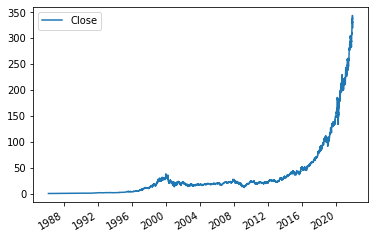

In [4]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

## Preparing the data

Ok, hopefully you've stopped kicking yourself for not buying Microsoft stock at any point in the past 30 years now. 

Now, let's prepare the data so we can make predictions.  As we mentioned in the introduction, we'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict.  Our target will be if the price will go up or down tomorrow.  If the price went up, the target will be `1`, and if it went down, the target will be `0`.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price.  This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

### Setting up the target

First, we setup the target.  

We do this by first copying the `Close` column to a new DataFrame called `data` and renaming it to `actual_close`.  This ensures that we can continue to see the value that the stock actually closed at on each day.  (we'll be shifting things around later, so it's important to preserve this).

Then, we setup our target by doing the following:

* Using the pandas [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html?highlight=rolling#pandas.DataFrame.rolling) method across every 2 rows of the DataFrame.  This will first look at ('1986-03-13', '1986-03-14'), then ('1986-03-14', '1986-03-17'), and so on across the DataFrame.
* We will compare the second row to the first row to see if it is greater.  If it is, return 1, otherwise 0.
* We then just look at the `Close` column.

As you can see above, the `Target` column now indicates if the price went up or down on the given day.  If `Target` is `1`, the price went up.  If `Target` is `0`, the price went down.

This is what we want our machine learning model to predict!

In [5]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [6]:
data.head()

,Actual_Close,Target
1986-03-13,0.061378,NaN
1986-03-14,0.063570,1.0
1986-03-17,0.064667,1.0
1986-03-18,0.063022,0.0
1986-03-19,0.061926,0.0


### Shifting data "forward"

Next, we'll use the DataFrame [shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html?highlight=shift#pandas.DataFrame.shift) method to move all rows "forward" one trading day.

As you can see, the prices for `1986-03-13` are now associated with `1986-03-14`, and every other price is shifted up one row.  This is to ensure that we're predicting future prices using past data.

If we didn't do this, we'd be using data from `03-14` to predict prices on `03-14`.  Instead, we need to use data from `03-13` to predict prices on `03-14`.  If we don't do this, our model will look amazing when we're testing it, but won't work at all in the real world.  In the real world, we don't actually know the price tomorrow, so we can't use it to make our predictions.

In [7]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [8]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0
1986-03-19,0.064667,0.065215,0.062474,0.063022,6.776640e+07,0.0,0.0


### Combining our data

Next, we need to combine our `Target` with the columns we want to use to predict the target.  We'll use this with the [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html?highlight=join#pandas.DataFrame.join) method on DataFrames.

After we join our data, we see that we'll be predicting the target using data from the previous day.  The columns we'll use to predict our target are `["Close", "Volume", "Open", "High", "Low"]`.

It's good to be explicit with `predictors` to avoid accidentally using your target to predict itself.  This will make your model look really good in training, but won't work at all in the real world.

In [9]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [10]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14,0.063570,1.0,0.061378,1.031789e+09,0.055898,0.064119,0.055898
1986-03-17,0.064667,1.0,0.063570,3.081600e+08,0.061378,0.064667,0.061378
1986-03-18,0.063022,0.0,0.064667,1.331712e+08,0.063570,0.065215,0.063570
1986-03-19,0.061926,0.0,0.063022,6.776640e+07,0.064667,0.065215,0.062474
1986-03-20,0.060282,0.0,0.061926,4.789440e+07,0.063022,0.063570,0.061378


## Creating a machine learning model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset.  This will cause leakage where data from the future will be used to predict past prices.  This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially.  We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions.  This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

This is just to setup our model and ensure that things are working properly.  To get an accurate error metric, we need to backtest across our entire price history.  Once we setup the model, this will be our next step.

### Setting up the model

First, we'll import a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`.  We can install `scikit-learn` with `pip install scikit-learn`.

We're using a classification algorithm because our target is binary (0/1).  A `1` means the price went up, a `0` means it went down.  If we had a different type of target (like the actual price), we might use a regression algorithm.

When we initialize the model, we pass in a few parameters:

* n_estimators - this is the number of individual decision trees that the algorithm should create.  A random forest is an [ensemble](https://scikit-learn.org/stable/modules/ensemble.html#ensemble) of decision trees that is more robust to overfitting than an individual tree.  The more trees, the more robust the algorithm, but fewer trees means it runs faster.
* min_samples_split - this is minimum number of samples any decision tree should split on.  The lower this is, the more prone the trees are to overfitting.  Setting it higher also makes it run faster.
* random_state - this is nice to set so that running the algorithm twice over the same data returns the same results.

In [11]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

### Training the model

Once we've setup the model, we can train it on the last `100` rows of the dataset.  We're using all of the data except the last `100` rows to predict the last `100` rows.  When you're working with time series data, it's important to never use future data to predict the past.

The [fit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit) method will train the model using our predictors to predict the `Target`.

In [12]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

### Measuring error

Next, we'll need to check how accurate the model was.  Earlier, we mentioned using `precision` to measure error.  We can do this by using the `precision_score` function from scikit-learn.

Precision will tell us on what % of days that the algorithm said the price would go up it actually went up.  Because we want to minimize risk, we want to have a high precision.  This means that when we buy stock, we have high confidence that we'll make money.

Below, we do the following to calculate precision:

* Import the scikit-learn `precision_score` function
* Generate predictions from our model using the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) function.  This will give us a `0` or a `1` for each row.
* The `predict` method returns a numpy array.  To make it easier to work with, we'll turn it into a pandas Series.
* Finally, we execute the `precision_score` function, passing in the predictions and the target.

As you can see below, our precision is only `.51`, which is not great.  That means that when the model predicted that prices would go up, they only went up `51%` of the time.

In [13]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.51

Our model is directionally accurate 51% of the time.  This is only a little bit better than a coin flip!  We can take a deeper look at the individual predictions and the actuals, and see where we're off.

We can do this by plotting the target against the predictions.  We do this by first combining the `Target` column and `Predictions` column into one DataFrame using the [concat](https://pandas.pydata.org/docs/reference/api/pandas.concat.html?highlight=concat#pandas.concat) function.  This function joins two pandas objects.  In this case, each object is a series, so we want to join them on `axis=1`, so each one becomes a column.

Then, we can plot the DataFrame to visualize both columns.

As we can see, the model predicted that the price would go up every single day.  This is not ideal, but we've setup the model, and can now move on to backtesting.

<AxesSubplot:>

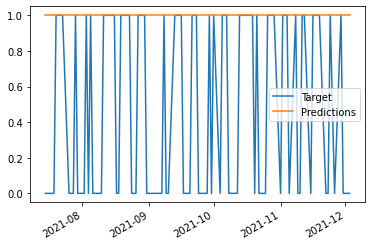

In [14]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

## Backtesting

Our model isn't great, but luckily we can still improve it.  Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows.  This will give us a more robust error estimate.  The last 100 days may have had atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

You wouldn't want to use an algorithm for anything in the real world if you only had 100 days of data to test it on.

To test on more days, we'll need to backtest.  Backtesting ensures that we only use data from before the day that we're predicting.  If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every `750` rows.  We'll make it a function so we can avoid rewriting the code if we want to backtest again.  Ideally, we'd train a model more often than every `750` rows, but for speed purposes we will set the number high.

Before we write our full backtesting loop, let's write the code for a single iteration.  In the below code:

* We'll take the first 1000 rows of the data as our training set
* We'll take the next 750 rows as our testing set
* We'll fit our machine learning model to the training set
* We'll make predictions on the test set

This is similar to what we did before, but we changed which rows we're looking at:

In [15]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

### Predicting probabilities

Next, let's add a little bit more precision.  We're using the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) method to generate predictions.  However, this method doesn't optimize for `precision`, which is what we care about.

By default, if the model thinks there is a 50% or higher chance of the price going up, it predicts that the price will go up.  Let's adjust this threshold to make the model only predict the price will go up when it is more confident.  We'll set this threshold to `.6`.

To do this, we need to use the [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) method.  This method enables us to get the raw probabilities, not just `0/1`.

In the code below, we:

* Use the `predict_proba` method to get the probabilities that the price will go up instead of just `0/1`.
* Take the second column of the result, to ensure that we only get the probability that the price will go up.
* convert the result from a numpy array to a pandas Series to make it easier to work with.
* If the % chance that the price will go up is >60%, then say the price will go up.

As you can see, `preds` gives us the prediction of the model on each day.

In [16]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [17]:
preds.head()

1990-02-27    1.0
1990-02-28    1.0
1990-03-01    1.0
1990-03-02    1.0
1990-03-05    1.0
dtype: float64

### Pulling it into a loop

Next, we can pull together everything we have done into a loop.  This loop will enable us to iterate across the entire dataset, generate predictions, and add them into the `predictions` list.

We'll get predictions for all but the first 1000 rows of the dataset.  This is because there is no previous data we can use to predict those rows.

In this loop, we:

* Generate predictions on our train and test set
* Combine those predictions with the actual target
* Add all the predictions into one list

As you can see, looking at the first element of the `predictions` list shows us the actual `Target` and the `Predictions` our model made.

In [18]:
predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [19]:
predictions[0].head()

,Target,Predictions
1990-02-27,0.0,1.0
1990-02-28,1.0,1.0
1990-03-01,1.0,1.0
1990-03-02,1.0,1.0
1990-03-05,1.0,1.0


### Creating a backtesting function

Finally, we'll wrap the loop in a function, to make it easier to work with.  A function means we can easily call it later.  The function will take the `data`, the machine learning `model`, and the `predictors` as inputs.  We'll also set `start` and `step` as optional parameters.  

In the backtesting function, we will:

* Split the training and test data
* Train a model
* Make predictions on the test data using `predict_proba`
* Combine our predictions with the actual Target, so we can calculate error easily
* Return all of the predictions

This function will enable us to create predictions across our whole dataset whenever we want.

In [20]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

### Running the function

Now that we've created a backtesting function, we can call it to generate predictions across the entire dataset.

In [21]:
predictions = backtest(data, model, predictors)

Next, let's use the [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts) method to identify how many times the algorithm predicted the price would go up versus down. 

As you can see, the algorithm only predicted that the price would go up `739` times.  In the `Target`, you see that the price actually went up `3945` times.  So the algorithm predicted the price would go up far fewer times than it actually did.  This means that the algorithm had low `recall`, which is the % chance of finding all of the days where the price went up.

This is because we used `.6` as a threshold for whether the price would go up or not.  If we used a lower threshold, we would increase recall, but lower precision.  Since we want to minimize our risk, we want to maximize precision.  So it's okay if the algorithm only predicts the price will go up on very few days.

In [22]:
predictions["Predictions"].value_counts()

0.0    7267
1.0     739
Name: Predictions, dtype: int64

In [23]:
predictions["Target"].value_counts()

1.0    4061
0.0    3945
Name: Target, dtype: int64

Finally, let's look at precision.  We can use the same function from before to evaluate this.

It looks like we have a low precision as well.  This is because the algorithm has limited `predictors` to help it determine if the price will go up or down.  We'll add some more predictors next to help the algorithm make better decisions.

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.503382949932341

## Improving accuracy

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock.  For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices.  We'll also look at the ratios between different indicators.

### Rolling means

Rolling means are useful because they can help the algorithm evaluate the current price against the average price this week, quarter, or year.  For example, if the price now is higher than the annual price, it could mean that the stock is on an upward trend.

To calculate the rolling averages, we'll again use the pandas [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html?highlight=rolling#pandas.DataFrame.rolling) method to find the rolling mean of the `Close` column for different time horizons.

In [25]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

We can also tell the algorithm how many days in the last week the price has gone up.  We can do this by using the pandas `shift` and `rolling` methods:

* We'll shift the data forward, so we're not incorporating information from the current day into our predictor.  If we didn't use shift, then the algorithm would have knowledge of the actual target.
* Find the 7-day rolling sum of the target.  If the price went up for all 7 days, this would be `7`.  If it went up 0 days, this would be `0`.

In [26]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

Now, we're ready to add our ratios into our predictor DataFrame.

First, we'll add the ratios between the weekly, quarterly, and annual means to the close:

In [27]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

Next, we'll add in the ratios between different rolling means.  This helps the algorithm understand what the weekly trend is relative to the annual trend.

In [28]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

Next, we'll add our weekly trend into the predictor DataFrame.

In [29]:
data["weekly_trend"] = weekly_trend

Then, we'll add some ratios between intraday open, low, and high prices and the close price.  This helps the algorithm understand what the price trend was during the last day.  For example, if the high was much higher than the close price, it may mean that the stock was on a downward trend at the end of the day.

In [30]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

Finally, we'll update our `predictors` list with all of the new predictors we added.  This ensures that we use all of our new predictors when we're training the model.

In [31]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

### Updating our predictions

We can now update our predictions with our new predictors.  We have to cut off the first `365` rows because our rolling means will have `NaN` values for the first `365` rows.  We want to make sure we have consistent data for every row that we make predictions for.

As we can see, our predictions are much more accurate than before!

In [32]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [33]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5979381443298969

### Evaluating our predictions

Now, we can check to see how many trades we would have made.  We can again do this with `value_counts`. 

As you can see, we would have made `194` trades using this algorithm.  We'd have had a close to `60%` chance that the price went up when our algorithm thought it would.  This is a decent start, but there are a lot of next steps we can take to improve the algorithm further!

In [34]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7447
1.0     194
Name: Predictions, dtype: int64

<AxesSubplot:>

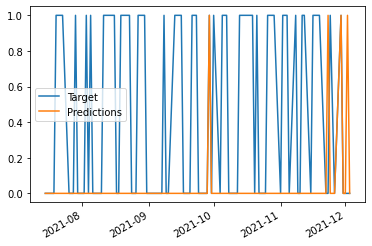

In [35]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()

## Next steps

We've come far in this project!  So far, we have:

* Downloaded data for a stock
* Cleaned and explored the data
* Created a machine learning model
* Created a backtesting function
* Improved our predictions

We now have a model that we can continue to build on and tweak.  The biggest area we can tweak is to continue to improve the accuracy of our predictions.  

There are a lot of next steps we could take:

**Improve the technique**

* Calculate how much money you'd make if you traded with this algorithm

**Improve the algorithm**

* Run with a reduced step size!  This will take longer, but increase accuracy
* Try discarding older data (only keeping data in a certain window)
* Try a different machine learning algorithm
* Tweak random forest parameters, or the prediction threshold

**Add in more predictors**

* Add in intraday trading day
    * See if you can add in hourly trends from the day before
* Account for activity post-close and pre-open
    * Early trading
    * Trading on other exchanges that open before the NYSE (to see what the global sentiment is)
* Economic indicators
    * Interest rates
    * Other important economic news
* Key dates
    * Dividends
    * External factors like elections
* Company milestones
    * Earnings calls
    * Analyst ratings
    * Major announcements
* Prices of related stocks
    * Other companies in the same sector
    * Key partners, customers, etc.
    
Hopefully this project has been helpful, and you now have something you can add to your portfolio.  As you build out your project, I'd recommend ensuring that you document your key choices, and explain to the reader why you made the choices you did.  You can see an [example](https://github.com/dataquestio/project-walkthroughs/blob/master/stock/StockProject.ipynb) of this completed project for inspiration.


Stay tuned for more project walkthrough posts!